# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:30]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 6479
Number of valid images: 2192
Number of test images: 2129


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 15
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [8]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['-', 'K', '-', 'R', '-', 'B', '-', '-']
['-', 'P', 'P', '-', 'N', '-', 'P', '-']
['P', '-', '-', 'Q', 'B', '-', '-', 'R']
['-', '-', '-', '-', 'n', 'P', '-', 'P']
['-', '-', 'b', '-', '-', '-', '-', 'p']
['-', 'p', '-', '-', '-', 'p', 'n', '-']
['p', 'b', 'p', 'p', '-', 'q', 'p', '-']
['-', 'k', '-', '-', 'r', '-', '-', '-']


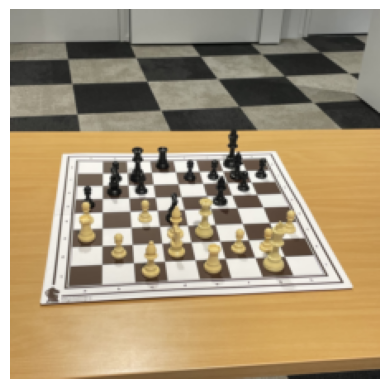

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


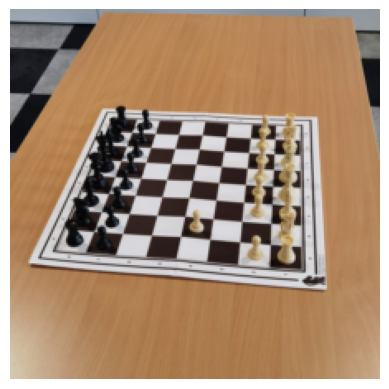

In [9]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 64),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()).round().astype(int)
    all_labels = all_labels.detach().numpy().astype(int)
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    #print("Test1 :",all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    return accuracy, recall, precision, f1

## Train the model

Define function to perform one iteration

In [12]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32]
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.append(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [13]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [14]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 431/431 [01:29<00:00,  4.81it/s]


Train loss: 12.05587 	 Train acc: 0.00000 	 Train recall: 0.15127 	 Train precision: 0.19310 	 Train f1: 0.07717


100%|██████████| 147/147 [00:09<00:00, 15.14it/s]


Val loss: 11.47682 	 Val acc: 0.00000 	 Val recall: 0.15148 	 Val precision: 0.18725 	 Val f1: 0.09286

Epoch 2


100%|██████████| 431/431 [01:29<00:00,  4.79it/s]


Train loss: 8.81214 	 Train acc: 0.00000 	 Train recall: 0.18697 	 Train precision: 0.20921 	 Train f1: 0.12650


100%|██████████| 147/147 [00:10<00:00, 14.36it/s]


Val loss: 9.20624 	 Val acc: 0.00000 	 Val recall: 0.19445 	 Val precision: 0.20750 	 Val f1: 0.14035

Epoch 3


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 5.52818 	 Train acc: 0.00000 	 Train recall: 0.22836 	 Train precision: 0.23513 	 Train f1: 0.17979


100%|██████████| 147/147 [00:10<00:00, 14.69it/s]


Val loss: 6.20360 	 Val acc: 0.00000 	 Val recall: 0.23696 	 Val precision: 0.23347 	 Val f1: 0.18958

Epoch 4


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 2.68689 	 Train acc: 0.00000 	 Train recall: 0.28148 	 Train precision: 0.27126 	 Train f1: 0.23640


100%|██████████| 147/147 [00:10<00:00, 14.59it/s]


Val loss: 3.18591 	 Val acc: 0.00000 	 Val recall: 0.26628 	 Val precision: 0.26030 	 Val f1: 0.22873

Epoch 5


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 1.29504 	 Train acc: 0.00000 	 Train recall: 0.33430 	 Train precision: 0.30671 	 Train f1: 0.28586


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 2.08944 	 Val acc: 0.00000 	 Val recall: 0.29993 	 Val precision: 0.27768 	 Val f1: 0.25149

Epoch 6


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.76303 	 Train acc: 0.00000 	 Train recall: 0.39884 	 Train precision: 0.35468 	 Train f1: 0.34496


100%|██████████| 147/147 [00:10<00:00, 14.66it/s]


Val loss: 1.41649 	 Val acc: 0.00000 	 Val recall: 0.36252 	 Val precision: 0.31863 	 Val f1: 0.30198

Epoch 7


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.53626 	 Train acc: 0.00000 	 Train recall: 0.45429 	 Train precision: 0.39798 	 Train f1: 0.39658


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 1.02116 	 Val acc: 0.00000 	 Val recall: 0.39899 	 Val precision: 0.34516 	 Val f1: 0.33360

Epoch 8


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.42433 	 Train acc: 0.00000 	 Train recall: 0.49967 	 Train precision: 0.43598 	 Train f1: 0.44028


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 1.07897 	 Val acc: 0.00000 	 Val recall: 0.40660 	 Val precision: 0.35464 	 Val f1: 0.34311

Epoch 9


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.41785 	 Train acc: 0.00000 	 Train recall: 0.50443 	 Train precision: 0.43990 	 Train f1: 0.44607


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.86962 	 Val acc: 0.00000 	 Val recall: 0.42794 	 Val precision: 0.36536 	 Val f1: 0.36179

Epoch 10


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.46805 	 Train acc: 0.00015 	 Train recall: 0.49289 	 Train precision: 0.42956 	 Train f1: 0.43544


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 1.10622 	 Val acc: 0.00000 	 Val recall: 0.40819 	 Val precision: 0.34494 	 Val f1: 0.33617

Epoch 11


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.32776 	 Train acc: 0.00015 	 Train recall: 0.54895 	 Train precision: 0.48339 	 Train f1: 0.49434


100%|██████████| 147/147 [00:10<00:00, 14.48it/s]


Val loss: 0.71999 	 Val acc: 0.00046 	 Val recall: 0.48758 	 Val precision: 0.41256 	 Val f1: 0.41526

Epoch 12


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.24882 	 Train acc: 0.00046 	 Train recall: 0.59499 	 Train precision: 0.53175 	 Train f1: 0.54601


100%|██████████| 147/147 [00:10<00:00, 14.69it/s]


Val loss: 0.65661 	 Val acc: 0.00000 	 Val recall: 0.48177 	 Val precision: 0.41410 	 Val f1: 0.41539

Epoch 13


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.24194 	 Train acc: 0.00155 	 Train recall: 0.60605 	 Train precision: 0.54302 	 Train f1: 0.55872


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 0.74461 	 Val acc: 0.00000 	 Val recall: 0.46002 	 Val precision: 0.39566 	 Val f1: 0.39183

Epoch 14


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.29694 	 Train acc: 0.00062 	 Train recall: 0.57477 	 Train precision: 0.50823 	 Train f1: 0.52268


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 0.80097 	 Val acc: 0.00000 	 Val recall: 0.46635 	 Val precision: 0.39429 	 Val f1: 0.39821

Epoch 15


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.29753 	 Train acc: 0.00015 	 Train recall: 0.57610 	 Train precision: 0.51086 	 Train f1: 0.52539


100%|██████████| 147/147 [00:10<00:00, 14.54it/s]


Val loss: 0.59334 	 Val acc: 0.00137 	 Val recall: 0.48726 	 Val precision: 0.42515 	 Val f1: 0.43190

Epoch 16


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.19968 	 Train acc: 0.00139 	 Train recall: 0.63574 	 Train precision: 0.58014 	 Train f1: 0.59686


100%|██████████| 147/147 [00:09<00:00, 14.71it/s]


Val loss: 0.69649 	 Val acc: 0.00000 	 Val recall: 0.49056 	 Val precision: 0.42658 	 Val f1: 0.43212

Epoch 17


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.25143 	 Train acc: 0.00170 	 Train recall: 0.60738 	 Train precision: 0.54433 	 Train f1: 0.56142


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.56863 	 Val acc: 0.00137 	 Val recall: 0.52054 	 Val precision: 0.44439 	 Val f1: 0.45695

Epoch 18


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.15480 	 Train acc: 0.00681 	 Train recall: 0.68193 	 Train precision: 0.63142 	 Train f1: 0.64809


100%|██████████| 147/147 [00:10<00:00, 14.51it/s]


Val loss: 0.58319 	 Val acc: 0.00000 	 Val recall: 0.50843 	 Val precision: 0.43542 	 Val f1: 0.44559

Epoch 19


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.15332 	 Train acc: 0.00820 	 Train recall: 0.68703 	 Train precision: 0.63732 	 Train f1: 0.65390


100%|██████████| 147/147 [00:10<00:00, 14.68it/s]


Val loss: 0.54461 	 Val acc: 0.00091 	 Val recall: 0.53127 	 Val precision: 0.46350 	 Val f1: 0.47345

Epoch 20


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.11177 	 Train acc: 0.01593 	 Train recall: 0.73085 	 Train precision: 0.69131 	 Train f1: 0.70587


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.46678 	 Val acc: 0.02327 	 Val recall: 0.55226 	 Val precision: 0.49070 	 Val f1: 0.50223

Epoch 21


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.10460 	 Train acc: 0.02351 	 Train recall: 0.74587 	 Train precision: 0.70807 	 Train f1: 0.72233


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.46712 	 Val acc: 0.01369 	 Val recall: 0.55909 	 Val precision: 0.48806 	 Val f1: 0.50416

Epoch 22


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.36853 	 Train acc: 0.00186 	 Train recall: 0.57427 	 Train precision: 0.50286 	 Train f1: 0.52069


100%|██████████| 147/147 [00:10<00:00, 14.48it/s]


Val loss: 0.54414 	 Val acc: 0.00091 	 Val recall: 0.51312 	 Val precision: 0.45320 	 Val f1: 0.46392

Epoch 23


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.13733 	 Train acc: 0.00897 	 Train recall: 0.70044 	 Train precision: 0.65823 	 Train f1: 0.67363


100%|██████████| 147/147 [00:10<00:00, 14.55it/s]


Val loss: 0.52571 	 Val acc: 0.00000 	 Val recall: 0.51284 	 Val precision: 0.45414 	 Val f1: 0.46363

Epoch 24


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.10730 	 Train acc: 0.01841 	 Train recall: 0.73924 	 Train precision: 0.70133 	 Train f1: 0.71564


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.44281 	 Val acc: 0.01369 	 Val recall: 0.56030 	 Val precision: 0.51020 	 Val f1: 0.51659

Epoch 25


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.09487 	 Train acc: 0.03063 	 Train recall: 0.76379 	 Train precision: 0.73019 	 Train f1: 0.74312


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.44799 	 Val acc: 0.01277 	 Val recall: 0.56581 	 Val precision: 0.50690 	 Val f1: 0.51879

Epoch 26


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.09365 	 Train acc: 0.02753 	 Train recall: 0.76488 	 Train precision: 0.73092 	 Train f1: 0.74426


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.44848 	 Val acc: 0.01688 	 Val recall: 0.56677 	 Val precision: 0.50686 	 Val f1: 0.52004

Epoch 27


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.09700 	 Train acc: 0.02382 	 Train recall: 0.75677 	 Train precision: 0.72271 	 Train f1: 0.73614


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.50672 	 Val acc: 0.00091 	 Val recall: 0.54212 	 Val precision: 0.48914 	 Val f1: 0.49965

Epoch 28


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.11568 	 Train acc: 0.01640 	 Train recall: 0.73227 	 Train precision: 0.69271 	 Train f1: 0.70788


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.45197 	 Val acc: 0.00593 	 Val recall: 0.56182 	 Val precision: 0.50925 	 Val f1: 0.51925

Epoch 29


100%|██████████| 431/431 [01:31<00:00,  4.74it/s]


Train loss: 0.13138 	 Train acc: 0.01206 	 Train recall: 0.71976 	 Train precision: 0.67070 	 Train f1: 0.68922


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.50388 	 Val acc: 0.00684 	 Val recall: 0.52291 	 Val precision: 0.46587 	 Val f1: 0.47349

Epoch 30


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.26115 	 Train acc: 0.00449 	 Train recall: 0.64641 	 Train precision: 0.57980 	 Train f1: 0.60199


100%|██████████| 147/147 [00:10<00:00, 14.60it/s]


Val loss: 0.53134 	 Val acc: 0.01597 	 Val recall: 0.53831 	 Val precision: 0.47327 	 Val f1: 0.48738

Epoch 31


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.08862 	 Train acc: 0.03681 	 Train recall: 0.76584 	 Train precision: 0.73387 	 Train f1: 0.74651


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.41736 	 Val acc: 0.02783 	 Val recall: 0.57026 	 Val precision: 0.51580 	 Val f1: 0.52681

Epoch 32


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.06148 	 Train acc: 0.06172 	 Train recall: 0.81730 	 Train precision: 0.79597 	 Train f1: 0.80480


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.40654 	 Val acc: 0.03193 	 Val recall: 0.57549 	 Val precision: 0.52395 	 Val f1: 0.53410

Epoch 33


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.04728 	 Train acc: 0.09977 	 Train recall: 0.85086 	 Train precision: 0.83522 	 Train f1: 0.84200


100%|██████████| 147/147 [00:10<00:00, 14.48it/s]


Val loss: 0.45647 	 Val acc: 0.03239 	 Val recall: 0.57877 	 Val precision: 0.51994 	 Val f1: 0.53346

Epoch 34


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.10471 	 Train acc: 0.02444 	 Train recall: 0.76034 	 Train precision: 0.71718 	 Train f1: 0.73496


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 0.45141 	 Val acc: 0.02099 	 Val recall: 0.56482 	 Val precision: 0.50507 	 Val f1: 0.51818

Epoch 35


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.07907 	 Train acc: 0.03728 	 Train recall: 0.78911 	 Train precision: 0.76125 	 Train f1: 0.77300


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.46768 	 Val acc: 0.00274 	 Val recall: 0.55650 	 Val precision: 0.50788 	 Val f1: 0.51840

Epoch 36


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.06745 	 Train acc: 0.05491 	 Train recall: 0.80658 	 Train precision: 0.78570 	 Train f1: 0.79458


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.43217 	 Val acc: 0.03148 	 Val recall: 0.57069 	 Val precision: 0.52415 	 Val f1: 0.53341

Epoch 37


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.05019 	 Train acc: 0.09343 	 Train recall: 0.83902 	 Train precision: 0.82383 	 Train f1: 0.83048


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.51757 	 Val acc: 0.01186 	 Val recall: 0.54521 	 Val precision: 0.49474 	 Val f1: 0.50434

Epoch 38


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.10001 	 Train acc: 0.03372 	 Train recall: 0.77646 	 Train precision: 0.74121 	 Train f1: 0.75577


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.48175 	 Val acc: 0.00776 	 Val recall: 0.55690 	 Val precision: 0.50305 	 Val f1: 0.51554

Epoch 39


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.09356 	 Train acc: 0.03171 	 Train recall: 0.77622 	 Train precision: 0.74390 	 Train f1: 0.75700


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.55842 	 Val acc: 0.01186 	 Val recall: 0.54702 	 Val precision: 0.48794 	 Val f1: 0.50136

Epoch 40


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.12863 	 Train acc: 0.02181 	 Train recall: 0.74227 	 Train precision: 0.69463 	 Train f1: 0.71380


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.45723 	 Val acc: 0.02874 	 Val recall: 0.56514 	 Val precision: 0.51684 	 Val f1: 0.52645

Epoch 41


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.05152 	 Train acc: 0.09126 	 Train recall: 0.83251 	 Train precision: 0.81732 	 Train f1: 0.82384


100%|██████████| 147/147 [00:10<00:00, 14.58it/s]


Val loss: 0.38879 	 Val acc: 0.03193 	 Val recall: 0.58765 	 Val precision: 0.54426 	 Val f1: 0.55291

Epoch 42


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.12047 	 Train acc: 0.07873 	 Train recall: 0.77926 	 Train precision: 0.72798 	 Train f1: 0.74932


100%|██████████| 147/147 [00:10<00:00, 14.56it/s]


Val loss: 0.52037 	 Val acc: 0.01825 	 Val recall: 0.54769 	 Val precision: 0.48668 	 Val f1: 0.49967

Epoch 43


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.07917 	 Train acc: 0.05321 	 Train recall: 0.79760 	 Train precision: 0.76588 	 Train f1: 0.77962


100%|██████████| 147/147 [00:10<00:00, 14.51it/s]


Val loss: 0.50601 	 Val acc: 0.02418 	 Val recall: 0.56930 	 Val precision: 0.51223 	 Val f1: 0.52255

Epoch 44


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.04363 	 Train acc: 0.13318 	 Train recall: 0.86012 	 Train precision: 0.84719 	 Train f1: 0.85291


100%|██████████| 147/147 [00:10<00:00, 14.61it/s]


Val loss: 0.40788 	 Val acc: 0.03422 	 Val recall: 0.58181 	 Val precision: 0.54083 	 Val f1: 0.54858

Epoch 45


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.03555 	 Train acc: 0.16968 	 Train recall: 0.88336 	 Train precision: 0.87578 	 Train f1: 0.87914


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 0.39607 	 Val acc: 0.02190 	 Val recall: 0.58494 	 Val precision: 0.54452 	 Val f1: 0.55163

Epoch 46


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.02706 	 Train acc: 0.25568 	 Train recall: 0.90687 	 Train precision: 0.90318 	 Train f1: 0.90477


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.37860 	 Val acc: 0.04151 	 Val recall: 0.59594 	 Val precision: 0.55409 	 Val f1: 0.56268

Epoch 47


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.02714 	 Train acc: 0.26079 	 Train recall: 0.90822 	 Train precision: 0.90344 	 Train f1: 0.90559


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.36990 	 Val acc: 0.03832 	 Val recall: 0.59775 	 Val precision: 0.55698 	 Val f1: 0.56459

Epoch 48


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.02736 	 Train acc: 0.24733 	 Train recall: 0.90642 	 Train precision: 0.90221 	 Train f1: 0.90405


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 0.35056 	 Val acc: 0.03695 	 Val recall: 0.59958 	 Val precision: 0.56230 	 Val f1: 0.56983

Epoch 49


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.02888 	 Train acc: 0.22769 	 Train recall: 0.89960 	 Train precision: 0.89453 	 Train f1: 0.89680


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.35691 	 Val acc: 0.04471 	 Val recall: 0.59937 	 Val precision: 0.56217 	 Val f1: 0.56949

Epoch 50


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.03094 	 Train acc: 0.20913 	 Train recall: 0.89113 	 Train precision: 0.88661 	 Train f1: 0.88854


100%|██████████| 147/147 [00:10<00:00, 14.61it/s]


Val loss: 0.34539 	 Val acc: 0.04380 	 Val recall: 0.60532 	 Val precision: 0.56725 	 Val f1: 0.57528

Epoch 51


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.07143 	 Train acc: 0.14571 	 Train recall: 0.84731 	 Train precision: 0.82331 	 Train f1: 0.83425


100%|██████████| 147/147 [00:10<00:00, 14.54it/s]


Val loss: 0.90319 	 Val acc: 0.00046 	 Val recall: 0.50010 	 Val precision: 0.41513 	 Val f1: 0.43167

Epoch 52


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.13564 	 Train acc: 0.02614 	 Train recall: 0.74257 	 Train precision: 0.69724 	 Train f1: 0.71559


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 0.46424 	 Val acc: 0.00365 	 Val recall: 0.56120 	 Val precision: 0.51537 	 Val f1: 0.52390

Epoch 53


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.05148 	 Train acc: 0.10580 	 Train recall: 0.84585 	 Train precision: 0.82997 	 Train f1: 0.83702


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.38616 	 Val acc: 0.04197 	 Val recall: 0.59477 	 Val precision: 0.55415 	 Val f1: 0.56157

Epoch 54


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.02661 	 Train acc: 0.25878 	 Train recall: 0.90814 	 Train precision: 0.90339 	 Train f1: 0.90553


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.36628 	 Val acc: 0.04562 	 Val recall: 0.59865 	 Val precision: 0.56210 	 Val f1: 0.56945

Epoch 55


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.06472 	 Train acc: 0.17804 	 Train recall: 0.85997 	 Train precision: 0.83791 	 Train f1: 0.84794


100%|██████████| 147/147 [00:10<00:00, 14.47it/s]


Val loss: 0.55023 	 Val acc: 0.00137 	 Val recall: 0.54609 	 Val precision: 0.49774 	 Val f1: 0.50866

Epoch 56


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.05353 	 Train acc: 0.10333 	 Train recall: 0.84833 	 Train precision: 0.82990 	 Train f1: 0.83829


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.42395 	 Val acc: 0.03513 	 Val recall: 0.58582 	 Val precision: 0.54084 	 Val f1: 0.55094

Epoch 57


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.03951 	 Train acc: 0.17169 	 Train recall: 0.88420 	 Train precision: 0.87227 	 Train f1: 0.87778


100%|██████████| 147/147 [00:10<00:00, 14.54it/s]


Val loss: 0.45841 	 Val acc: 0.04288 	 Val recall: 0.57992 	 Val precision: 0.53158 	 Val f1: 0.54429

Epoch 58


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.03269 	 Train acc: 0.22521 	 Train recall: 0.90127 	 Train precision: 0.89309 	 Train f1: 0.89690


100%|██████████| 147/147 [00:10<00:00, 14.56it/s]


Val loss: 0.43357 	 Val acc: 0.04380 	 Val recall: 0.58963 	 Val precision: 0.54296 	 Val f1: 0.55314

Epoch 59


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.06859 	 Train acc: 0.09296 	 Train recall: 0.84269 	 Train precision: 0.81898 	 Train f1: 0.82968


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.47930 	 Val acc: 0.02235 	 Val recall: 0.58288 	 Val precision: 0.53898 	 Val f1: 0.54982

Epoch 60


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.03611 	 Train acc: 0.18329 	 Train recall: 0.88374 	 Train precision: 0.87351 	 Train f1: 0.87817


100%|██████████| 147/147 [00:10<00:00, 14.69it/s]


Val loss: 0.39376 	 Val acc: 0.03741 	 Val recall: 0.58915 	 Val precision: 0.55563 	 Val f1: 0.55968

Epoch 61


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.02036 	 Train acc: 0.36999 	 Train recall: 0.92838 	 Train precision: 0.92798 	 Train f1: 0.92807


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.37248 	 Val acc: 0.04471 	 Val recall: 0.60112 	 Val precision: 0.57053 	 Val f1: 0.57384

Epoch 62


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.01654 	 Train acc: 0.46280 	 Train recall: 0.94418 	 Train precision: 0.94484 	 Train f1: 0.94445


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.36794 	 Val acc: 0.04881 	 Val recall: 0.60317 	 Val precision: 0.57443 	 Val f1: 0.57730

Epoch 63


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.03849 	 Train acc: 0.33271 	 Train recall: 0.90977 	 Train precision: 0.89882 	 Train f1: 0.90401


100%|██████████| 147/147 [00:10<00:00, 14.57it/s]


Val loss: 0.58162 	 Val acc: 0.02190 	 Val recall: 0.55508 	 Val precision: 0.50386 	 Val f1: 0.51540

Epoch 64


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.11496 	 Train acc: 0.02800 	 Train recall: 0.77607 	 Train precision: 0.73370 	 Train f1: 0.75162


100%|██████████| 147/147 [00:10<00:00, 13.90it/s]


Val loss: 0.61496 	 Val acc: 0.00046 	 Val recall: 0.56298 	 Val precision: 0.48960 	 Val f1: 0.50832

Epoch 65


100%|██████████| 431/431 [01:32<00:00,  4.66it/s]


Train loss: 0.06143 	 Train acc: 0.10240 	 Train recall: 0.84382 	 Train precision: 0.82231 	 Train f1: 0.83218


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.42820 	 Val acc: 0.03650 	 Val recall: 0.59230 	 Val precision: 0.55333 	 Val f1: 0.56115

Epoch 66


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.02914 	 Train acc: 0.29977 	 Train recall: 0.91462 	 Train precision: 0.90957 	 Train f1: 0.91193


100%|██████████| 147/147 [00:10<00:00, 14.56it/s]


Val loss: 0.53136 	 Val acc: 0.03604 	 Val recall: 0.58458 	 Val precision: 0.54598 	 Val f1: 0.55304

Epoch 67


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.04052 	 Train acc: 0.21036 	 Train recall: 0.89574 	 Train precision: 0.88626 	 Train f1: 0.89059


100%|██████████| 147/147 [00:10<00:00, 14.65it/s]


Val loss: 0.47659 	 Val acc: 0.03604 	 Val recall: 0.58751 	 Val precision: 0.54028 	 Val f1: 0.55227

Epoch 68


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.03632 	 Train acc: 0.21361 	 Train recall: 0.89907 	 Train precision: 0.88812 	 Train f1: 0.89328


100%|██████████| 147/147 [00:10<00:00, 14.57it/s]


Val loss: 0.44828 	 Val acc: 0.03650 	 Val recall: 0.58626 	 Val precision: 0.54687 	 Val f1: 0.55494

Epoch 69


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.02111 	 Train acc: 0.37015 	 Train recall: 0.92998 	 Train precision: 0.92790 	 Train f1: 0.92884


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.42485 	 Val acc: 0.04608 	 Val recall: 0.59768 	 Val precision: 0.56223 	 Val f1: 0.56780

Epoch 70


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.01422 	 Train acc: 0.52637 	 Train recall: 0.95475 	 Train precision: 0.95481 	 Train f1: 0.95472


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.40048 	 Val acc: 0.04562 	 Val recall: 0.60019 	 Val precision: 0.57119 	 Val f1: 0.57489

Epoch 71


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01370 	 Train acc: 0.56195 	 Train recall: 0.95720 	 Train precision: 0.95846 	 Train f1: 0.95780


100%|██████████| 147/147 [00:10<00:00, 14.67it/s]


Val loss: 0.39483 	 Val acc: 0.04653 	 Val recall: 0.59847 	 Val precision: 0.57143 	 Val f1: 0.57389

Epoch 72


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.01409 	 Train acc: 0.53534 	 Train recall: 0.95477 	 Train precision: 0.95559 	 Train f1: 0.95514


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.39448 	 Val acc: 0.04288 	 Val recall: 0.60447 	 Val precision: 0.57411 	 Val f1: 0.57785

Epoch 73


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01604 	 Train acc: 0.46172 	 Train recall: 0.94454 	 Train precision: 0.94425 	 Train f1: 0.94433


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.37506 	 Val acc: 0.04881 	 Val recall: 0.60942 	 Val precision: 0.57802 	 Val f1: 0.58285

Epoch 74


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.01899 	 Train acc: 0.40000 	 Train recall: 0.93328 	 Train precision: 0.93358 	 Train f1: 0.93335


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.39162 	 Val acc: 0.04745 	 Val recall: 0.60976 	 Val precision: 0.57634 	 Val f1: 0.58233

Epoch 75


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.11418 	 Train acc: 0.07904 	 Train recall: 0.80145 	 Train precision: 0.75655 	 Train f1: 0.77599


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.78542 	 Val acc: 0.00502 	 Val recall: 0.52623 	 Val precision: 0.46086 	 Val f1: 0.47606

Epoch 76


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.06060 	 Train acc: 0.11199 	 Train recall: 0.83977 	 Train precision: 0.81786 	 Train f1: 0.82790


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.43006 	 Val acc: 0.03604 	 Val recall: 0.58851 	 Val precision: 0.55304 	 Val f1: 0.55911

Epoch 77


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.02147 	 Train acc: 0.36613 	 Train recall: 0.93048 	 Train precision: 0.92820 	 Train f1: 0.92924


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.39908 	 Val acc: 0.04151 	 Val recall: 0.59698 	 Val precision: 0.56596 	 Val f1: 0.57011

Epoch 78


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01319 	 Train acc: 0.58097 	 Train recall: 0.96068 	 Train precision: 0.96234 	 Train f1: 0.96148


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.38098 	 Val acc: 0.04699 	 Val recall: 0.60077 	 Val precision: 0.57589 	 Val f1: 0.57686

Epoch 79


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01018 	 Train acc: 0.68136 	 Train recall: 0.97229 	 Train precision: 0.97394 	 Train f1: 0.97310


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.38031 	 Val acc: 0.04562 	 Val recall: 0.60248 	 Val precision: 0.58039 	 Val f1: 0.58000

Epoch 80


100%|██████████| 431/431 [01:31<00:00,  4.74it/s]


Train loss: 0.01039 	 Train acc: 0.67425 	 Train recall: 0.97107 	 Train precision: 0.97244 	 Train f1: 0.97174


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.36596 	 Val acc: 0.04699 	 Val recall: 0.60976 	 Val precision: 0.58456 	 Val f1: 0.58556

Epoch 81


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.01211 	 Train acc: 0.60325 	 Train recall: 0.96292 	 Train precision: 0.96426 	 Train f1: 0.96357


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.36886 	 Val acc: 0.04745 	 Val recall: 0.60591 	 Val precision: 0.58303 	 Val f1: 0.58330

Epoch 82


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.01444 	 Train acc: 0.51632 	 Train recall: 0.95243 	 Train precision: 0.95295 	 Train f1: 0.95264


100%|██████████| 147/147 [00:10<00:00, 14.59it/s]


Val loss: 0.36261 	 Val acc: 0.04927 	 Val recall: 0.60891 	 Val precision: 0.58517 	 Val f1: 0.58587

Epoch 83


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.01530 	 Train acc: 0.47951 	 Train recall: 0.94725 	 Train precision: 0.94858 	 Train f1: 0.94786


100%|██████████| 147/147 [00:10<00:00, 14.60it/s]


Val loss: 0.35757 	 Val acc: 0.04790 	 Val recall: 0.61236 	 Val precision: 0.58722 	 Val f1: 0.58792

Epoch 84


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01592 	 Train acc: 0.47053 	 Train recall: 0.94510 	 Train precision: 0.94606 	 Train f1: 0.94552


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.35684 	 Val acc: 0.04927 	 Val recall: 0.61065 	 Val precision: 0.58521 	 Val f1: 0.58695

Epoch 85


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.06646 	 Train acc: 0.24888 	 Train recall: 0.87405 	 Train precision: 0.84810 	 Train f1: 0.86017


100%|██████████| 147/147 [00:10<00:00, 14.53it/s]


Val loss: 0.80991 	 Val acc: 0.00593 	 Val recall: 0.54531 	 Val precision: 0.48589 	 Val f1: 0.49931

Epoch 86


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.06446 	 Train acc: 0.11384 	 Train recall: 0.84732 	 Train precision: 0.82410 	 Train f1: 0.83476


100%|██████████| 147/147 [00:10<00:00, 14.63it/s]


Val loss: 0.50392 	 Val acc: 0.02646 	 Val recall: 0.58354 	 Val precision: 0.53197 	 Val f1: 0.54705

Epoch 87


100%|██████████| 431/431 [01:31<00:00,  4.69it/s]


Train loss: 0.02466 	 Train acc: 0.31477 	 Train recall: 0.91742 	 Train precision: 0.91270 	 Train f1: 0.91493


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Val loss: 0.43642 	 Val acc: 0.04562 	 Val recall: 0.59651 	 Val precision: 0.56821 	 Val f1: 0.57196

Epoch 88


100%|██████████| 431/431 [01:31<00:00,  4.71it/s]


Train loss: 0.02528 	 Train acc: 0.39196 	 Train recall: 0.93280 	 Train precision: 0.92712 	 Train f1: 0.92988


100%|██████████| 147/147 [00:09<00:00, 14.73it/s]


Val loss: 0.45218 	 Val acc: 0.03923 	 Val recall: 0.59201 	 Val precision: 0.55053 	 Val f1: 0.56093

Epoch 89


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.03336 	 Train acc: 0.40340 	 Train recall: 0.92878 	 Train precision: 0.92184 	 Train f1: 0.92520


100%|██████████| 147/147 [00:09<00:00, 14.74it/s]


Val loss: 0.43975 	 Val acc: 0.02965 	 Val recall: 0.59599 	 Val precision: 0.55643 	 Val f1: 0.56456

Epoch 90


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.03014 	 Train acc: 0.30858 	 Train recall: 0.92054 	 Train precision: 0.91484 	 Train f1: 0.91753


100%|██████████| 147/147 [00:10<00:00, 14.66it/s]


Val loss: 0.58041 	 Val acc: 0.03558 	 Val recall: 0.58993 	 Val precision: 0.54531 	 Val f1: 0.55409

Epoch 91


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.02863 	 Train acc: 0.33797 	 Train recall: 0.92492 	 Train precision: 0.91924 	 Train f1: 0.92196


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.41806 	 Val acc: 0.04562 	 Val recall: 0.59593 	 Val precision: 0.56550 	 Val f1: 0.56937

Epoch 92


100%|██████████| 431/431 [01:31<00:00,  4.72it/s]


Train loss: 0.01755 	 Train acc: 0.48244 	 Train recall: 0.94991 	 Train precision: 0.94813 	 Train f1: 0.94897


100%|██████████| 147/147 [00:09<00:00, 14.75it/s]


Val loss: 0.40609 	 Val acc: 0.04653 	 Val recall: 0.60480 	 Val precision: 0.57932 	 Val f1: 0.58078

Epoch 93


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.02855 	 Train acc: 0.37046 	 Train recall: 0.93231 	 Train precision: 0.92480 	 Train f1: 0.92844


100%|██████████| 147/147 [00:10<00:00, 14.59it/s]


Val loss: 0.51057 	 Val acc: 0.03422 	 Val recall: 0.58694 	 Val precision: 0.54993 	 Val f1: 0.55762

Epoch 94


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.03435 	 Train acc: 0.25692 	 Train recall: 0.90842 	 Train precision: 0.90033 	 Train f1: 0.90424


100%|██████████| 147/147 [00:10<00:00, 14.64it/s]


Val loss: 0.49485 	 Val acc: 0.03513 	 Val recall: 0.58928 	 Val precision: 0.54873 	 Val f1: 0.55675

Epoch 95


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.02146 	 Train acc: 0.39227 	 Train recall: 0.93425 	 Train precision: 0.93227 	 Train f1: 0.93318


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.39212 	 Val acc: 0.04881 	 Val recall: 0.60436 	 Val precision: 0.57436 	 Val f1: 0.57772

Epoch 96


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.02789 	 Train acc: 0.41918 	 Train recall: 0.93235 	 Train precision: 0.92239 	 Train f1: 0.92726


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.44170 	 Val acc: 0.04653 	 Val recall: 0.59872 	 Val precision: 0.56195 	 Val f1: 0.56928

Epoch 97


100%|██████████| 431/431 [01:31<00:00,  4.73it/s]


Train loss: 0.03923 	 Train acc: 0.32544 	 Train recall: 0.91297 	 Train precision: 0.89874 	 Train f1: 0.90560


100%|██████████| 147/147 [00:10<00:00, 14.52it/s]


Val loss: 0.45619 	 Val acc: 0.03923 	 Val recall: 0.58729 	 Val precision: 0.54882 	 Val f1: 0.55663

Epoch 98


100%|██████████| 431/431 [01:30<00:00,  4.74it/s]


Train loss: 0.02217 	 Train acc: 0.43186 	 Train recall: 0.94022 	 Train precision: 0.93835 	 Train f1: 0.93921


100%|██████████| 147/147 [00:10<00:00, 14.57it/s]


Val loss: 0.44851 	 Val acc: 0.04060 	 Val recall: 0.59200 	 Val precision: 0.55977 	 Val f1: 0.56506

Epoch 99


100%|██████████| 431/431 [01:32<00:00,  4.67it/s]


Train loss: 0.01325 	 Train acc: 0.60944 	 Train recall: 0.96325 	 Train precision: 0.96472 	 Train f1: 0.96395


100%|██████████| 147/147 [00:10<00:00, 14.60it/s]


Val loss: 0.39976 	 Val acc: 0.04836 	 Val recall: 0.60279 	 Val precision: 0.57757 	 Val f1: 0.57835

Epoch 100


100%|██████████| 431/431 [01:32<00:00,  4.68it/s]


Train loss: 0.00930 	 Train acc: 0.71524 	 Train recall: 0.97489 	 Train precision: 0.97661 	 Train f1: 0.97573


100%|██████████| 147/147 [00:10<00:00, 14.62it/s]


Val loss: 0.40867 	 Val acc: 0.04699 	 Val recall: 0.60218 	 Val precision: 0.57963 	 Val f1: 0.57908
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [15]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

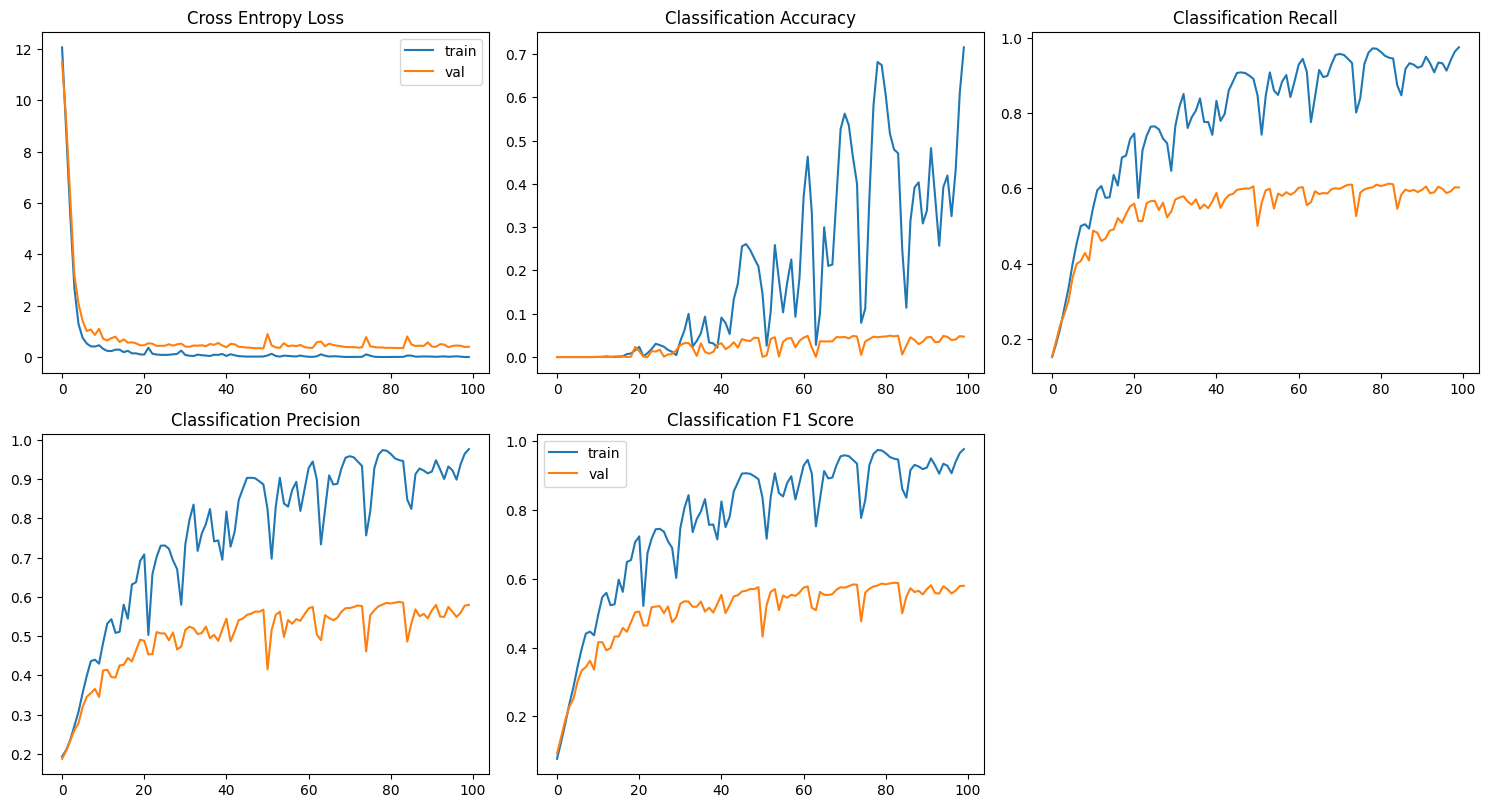

In [16]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [17]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.cpu()*12
            preds.append(predsTmp.cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds).round()
        all_labels = torch.cat(labels)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

100%|██████████| 142/142 [00:10<00:00, 13.79it/s]


Test accuracy: 0.051, Test recall: 0.597, Test precision: 0.578, Test f1: 0.577


  0%|          | 0/142 [00:00<?, ?it/s]

tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]], dtype=torch.int32)
tensor([[ 1,  2,  3,  5,  4,  3,  2,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [ 6,  6,  6,  6,  6,  6,  6,  6],
        [ 7,  8,  9, 11, 10,  9,  8,  7]])
Accuracy: 0.067, Recall: 0.885, Precision: 0.855, F1: 0.864


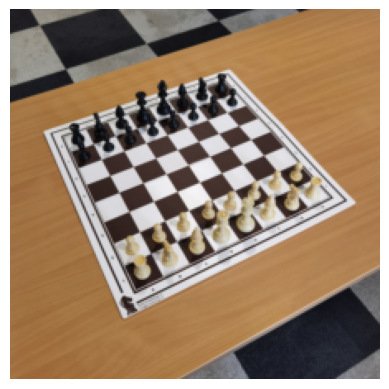

  1%|          | 1/142 [00:00<00:23,  6.02it/s]

tensor([[ 1, 12, 12,  5,  4, 12, 12,  1],
        [ 0,  0,  0,  3,  3, 12,  1, 12],
        [12, 12,  2,  0, 12,  3,  6,  0],
        [12, 12, 12, 12, 12,  0,  0, 12],
        [12, 12,  9, 12,  7, 12, 12, 12],
        [12, 12,  8,  7,  8,  8, 12, 12],
        [ 6,  6,  6, 12,  8, 12,  6,  6],
        [ 7, 12, 12, 11, 10, 12, 12,  7]], dtype=torch.int32)
tensor([[ 1, 12, 12,  5,  4, 12, 12,  1],
        [ 0,  0,  0,  3,  0, 12,  3, 12],
        [12, 12,  2,  0, 12,  2, 12,  0],
        [12, 12, 12, 12, 12,  0,  0, 12],
        [12, 12,  9, 12,  6, 12, 12, 12],
        [12, 12,  8,  6,  9,  6, 12, 12],
        [ 6,  6,  6, 12,  8, 12,  6,  6],
        [ 7, 12, 12, 11, 10, 12, 12,  7]])
Accuracy: 0.000, Recall: 0.748, Precision: 0.685, F1: 0.707


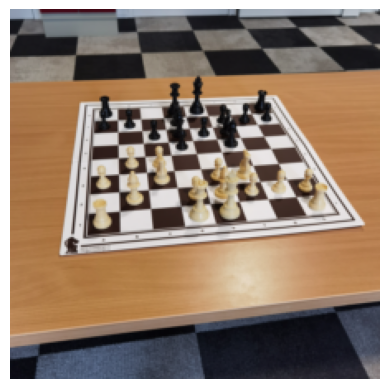

  1%|▏         | 2/142 [00:00<00:22,  6.18it/s]

tensor([[12,  5, 12,  1, 12, 12, 12,  1],
        [ 1,  0,  0, 12,  3, 12,  2, 12],
        [12, 12, 12,  0,  4,  2, 12,  0],
        [12, 12, 12, 12,  0, 12,  0, 12],
        [12, 12, 12, 12,  6, 12, 12, 12],
        [ 6, 12,  8, 12, 12,  7, 12,  6],
        [12,  6,  6,  8,  8, 12,  6, 12],
        [12, 11, 12,  7, 12, 12, 12,  7]], dtype=torch.int32)
tensor([[12,  5, 12,  1, 12, 12, 12,  1],
        [ 9,  0,  0, 12,  2, 12,  3, 12],
        [12, 12, 12,  0,  4,  2, 12,  0],
        [12, 12, 12, 12,  0, 12,  0, 12],
        [12, 12, 12, 12,  6, 12, 12, 12],
        [ 6, 12,  8, 12, 12,  6, 12,  6],
        [12,  6,  6, 10,  8, 12,  6, 12],
        [12, 11, 12,  7, 12, 12, 12,  7]])
Accuracy: 0.000, Recall: 0.451, Precision: 0.415, F1: 0.412


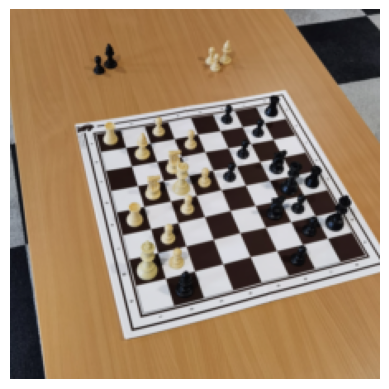

  2%|▏         | 3/142 [00:00<00:22,  6.19it/s]

tensor([[12, 12, 12,  2, 12, 12, 12,  3],
        [12,  2, 12, 12,  5, 12,  6, 12],
        [12,  3, 12,  0, 12, 12, 12,  0],
        [12, 12, 12, 11, 12, 12,  0, 12],
        [12, 12, 12, 12,  8,  1,  6, 12],
        [ 1, 12, 12, 12, 12,  7, 12,  6],
        [12,  6,  6, 12, 12, 12, 12, 12],
        [12, 11, 12,  7, 12, 12, 12,  7]], dtype=torch.int32)
tensor([[12, 12, 12,  1, 12, 12, 12,  1],
        [12,  0, 12, 12,  2, 12,  8, 12],
        [12,  5, 12,  0, 12, 12, 12,  0],
        [12, 12, 12, 12, 12, 12,  0, 12],
        [12, 12, 12, 12,  6,  0,  6, 12],
        [ 0, 12, 12, 12, 12,  6, 12,  6],
        [12,  6,  6, 12, 12, 12, 12, 12],
        [12, 11, 12,  7, 12, 12, 12,  7]])
Accuracy: 0.000, Recall: 0.307, Precision: 0.287, F1: 0.286


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


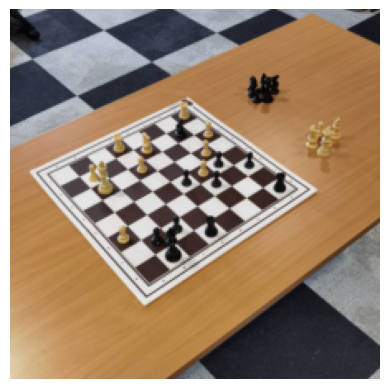

  3%|▎         | 4/142 [00:00<00:22,  6.13it/s]

tensor([[12, 12, 12, 12, 12, 12, 12,  2],
        [ 1,  0, 12,  5, 12,  3, 12, 12],
        [12, 12, 12,  1, 12, 12, 12, 12],
        [12, 12, 12,  7,  4,  6,  0, 12],
        [12, 12, 12, 12, 11,  0,  5, 12],
        [ 6,  7, 12, 12, 12,  7, 12, 12],
        [12, 12,  6, 12, 12, 12, 12, 12],
        [12, 11, 12, 12, 12, 12, 12, 12]], dtype=torch.int32)
tensor([[12, 12, 12, 12, 12, 12, 12,  1],
        [ 5,  0, 12,  1, 12,  2, 12, 12],
        [12, 12, 12,  0, 12, 12, 12, 12],
        [12, 12, 12,  7,  6,  8,  0, 12],
        [12, 12, 12, 12, 12,  0,  6, 12],
        [ 6,  7, 12, 12, 12,  6, 12, 12],
        [12, 12,  6, 12, 12, 12, 12, 12],
        [12, 11, 12, 12, 12, 12, 12, 12]])
Accuracy: 0.000, Recall: 0.353, Precision: 0.368, F1: 0.348


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


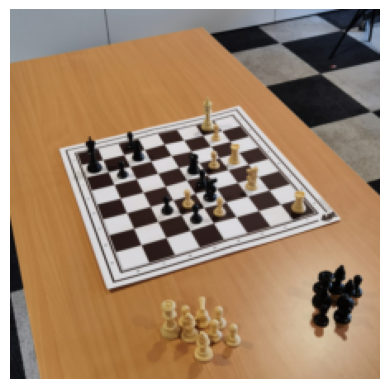

  4%|▎         | 5/142 [00:00<00:22,  6.17it/s]C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tensor([[12,  5, 12, 12, 12, 12, 12,  2],
        [12,  0, 12, 12,  3, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12,  8, 12, 12, 12, 12,  4, 12],
        [ 4, 12, 12, 12, 12,  0,  5, 12],
        [12, 12,  8, 12, 12,  7, 12, 12],
        [12, 12,  6, 12, 12, 12, 12, 12],
        [12, 11, 12, 12, 12, 12, 12, 12]], dtype=torch.int32)
tensor([[12,  5, 12, 12, 12, 12, 12,  1],
        [12,  0, 12, 12,  1, 12, 12, 12],
        [12, 12, 12, 12, 12, 12, 12, 12],
        [12,  8, 12, 12, 12, 12,  7, 12],
        [ 2, 12, 12, 12, 12,  0,  6, 12],
        [12, 12,  7, 12, 12,  6, 12, 12],
        [12, 12,  6, 12, 12, 12, 12, 12],
        [12, 11, 12, 12, 12, 12, 12, 12]])
Accuracy: 0.000, Recall: 0.384, Precision: 0.445, F1: 0.394


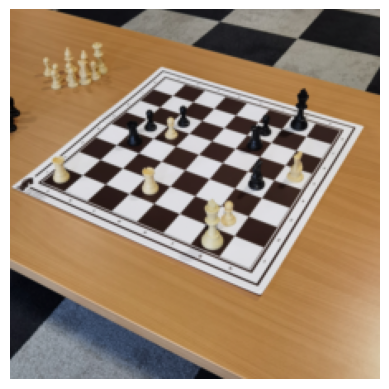

  4%|▎         | 5/142 [00:00<00:26,  5.15it/s]


In [18]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = (pred.cpu()*12).round().int()
            print(predsTmp[0].reshape(8, 8))
            print(y.cpu()[0].reshape(8, 8))
            #print(pred.cpu().shape, y.cpu().shape)
            pred1 = (pred.cpu()*12).round().int()
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(pred1, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?